In [1]:
%matplotlib inline

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import histlite as hl
import csky as cy

import matplotlib as mpl
mpl.style.use('/home/apizzuto/Nova/python3/scripts/novae_plots_nb.mplstyle')
#palette = sns.color_palette('Dark2')
palette = sns.color_palette('Paired')

In [3]:
timer = cy.timing.Timer()
time = timer.time

In [4]:
ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/')
with time('ana setup'):
    ana = cy.get_analysis(
        cy.selections.repo,
        'version-002-p05', cy.selections.GFUDataSpecs.GFU_IC86,
        dir=ana_dir)

Setting up Analysis for:
GFU_for_2011_2012_2013_2014_2015_2016_2017_2018
Setting up GFU_for_2011_2012_2013_2014_2015_2016_2017_2018...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_MC.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2013_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2014_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2015_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2016_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2017_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/IC86_2018_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2011_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2012_data.npy ...
Reading /data/ana/analyses/gfu/version-002-p05/GRL/IC86_2013_data.npy ...
Reading /data/a

In [21]:
ana.mjd_min

55694.41797495867

In [15]:
conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
       }
cy.CONF['mp_cpus'] = 5
sinDecs = [-0.5, 0.0, 0.5]
inj_gamma = [2.0, 2.5, 3.0]
delta_ts = np.logspace(3., 7., 9)

all_gamma_results = dict()

for gamma in inj_gamma:
    all_gamma_results[gamma] = dict()
    for sd in sinDecs:
        results = dict(sens_n = [],
                  sens_e2dnde = [],
                  disc_n = [],
                  disc_e2dnde = [],
                  delta_t = [])
        dec = np.arcsin(sd)
        for delta_t in delta_ts:
            src = cy.utils.Sources(ra=0.0,
                                   dec=dec,
                                   mjd=57000.,
                                   sigma_t=0.,
                                   t_100=delta_t/86400.)
            cy.CONF['src'] = src

            tr = cy.get_trial_runner(conf, ana=ana, src=src,
                                     inj_conf={'flux': cy.hyp.PowerLawFlux(gamma)})
            bg = cy.dists.Chi2TSD(tr.get_many_fits(5000))

            sensitivity = tr.find_n_sig(bg.median(), 0.9,
                                   batch_size=50,
                                   n_sig_step=3,
                                   max_batch_size=0,
                                   logging=False,
                                   n_bootstrap=1)

            thresh_ts = bg.isf_nsigma(5.)
            discovery = tr.find_n_sig(thresh_ts, 0.5,
                                   batch_size=50,
                                   n_sig_step=3,
                                   max_batch_size=0,
                                   logging=False,
                                   n_bootstrap=1)
            
            results['sens_n'].append(sensitivity['n_sig'])
            results['disc_n'].append(discovery['n_sig'])
            results['sens_e2dnde'].append(tr.to_E2dNdE(sensitivity, E0=100, unit=1e3))
            results['disc_e2dnde'].append(tr.to_E2dNdE(discovery['n_sig'], E0=100, unit=1e3))
            results['delta_t'].append(delta_t)
            
        all_gamma_results[gamma][sd] = results

Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
       5000/5000 trials complete.   
Performing 5000 background trials using 5 cores:
     

In [16]:
def conv_ref_en(fl, e1, e0, gamma):
    return np.asarray(fl) * (e1/e0)**(2.-gamma)

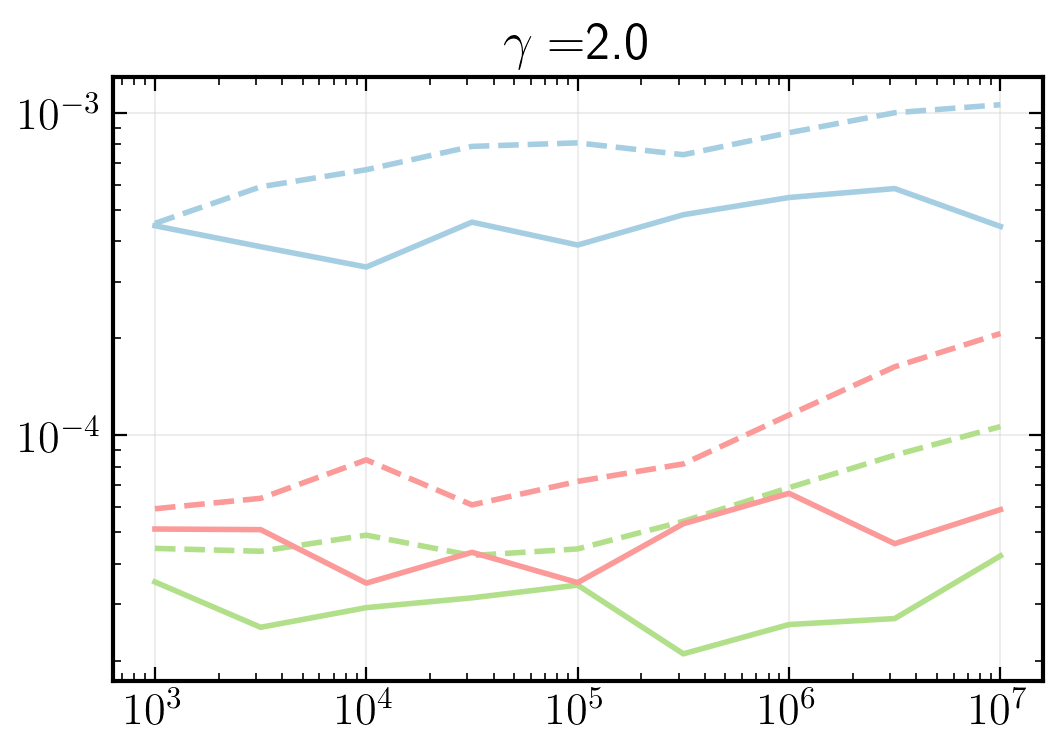

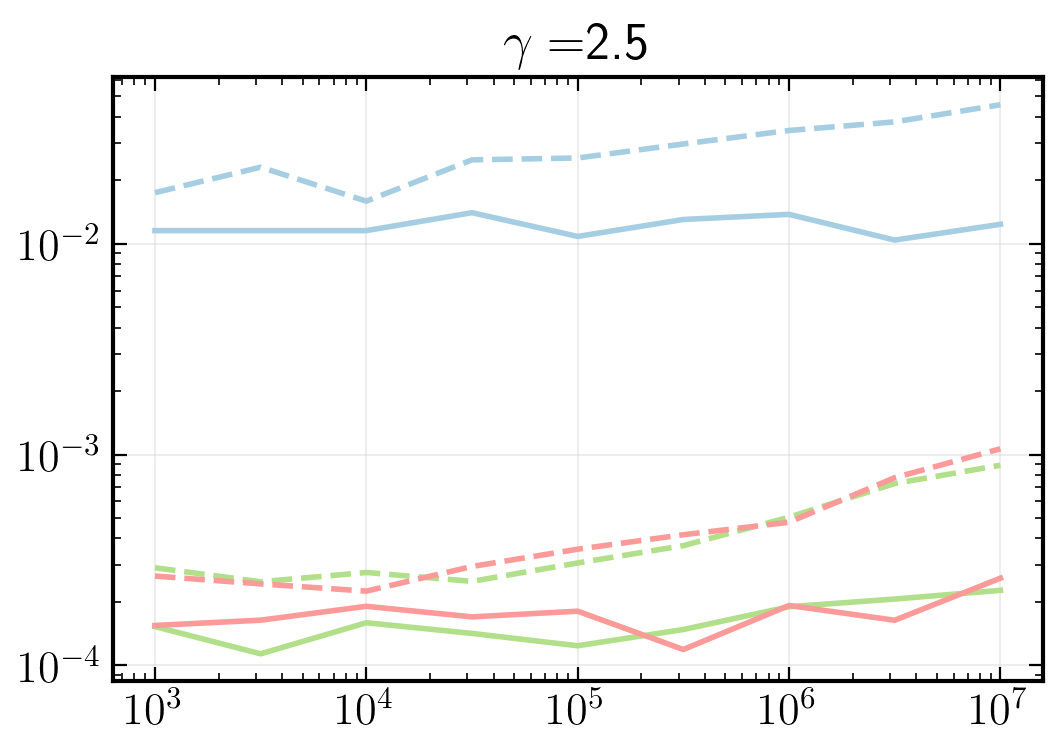

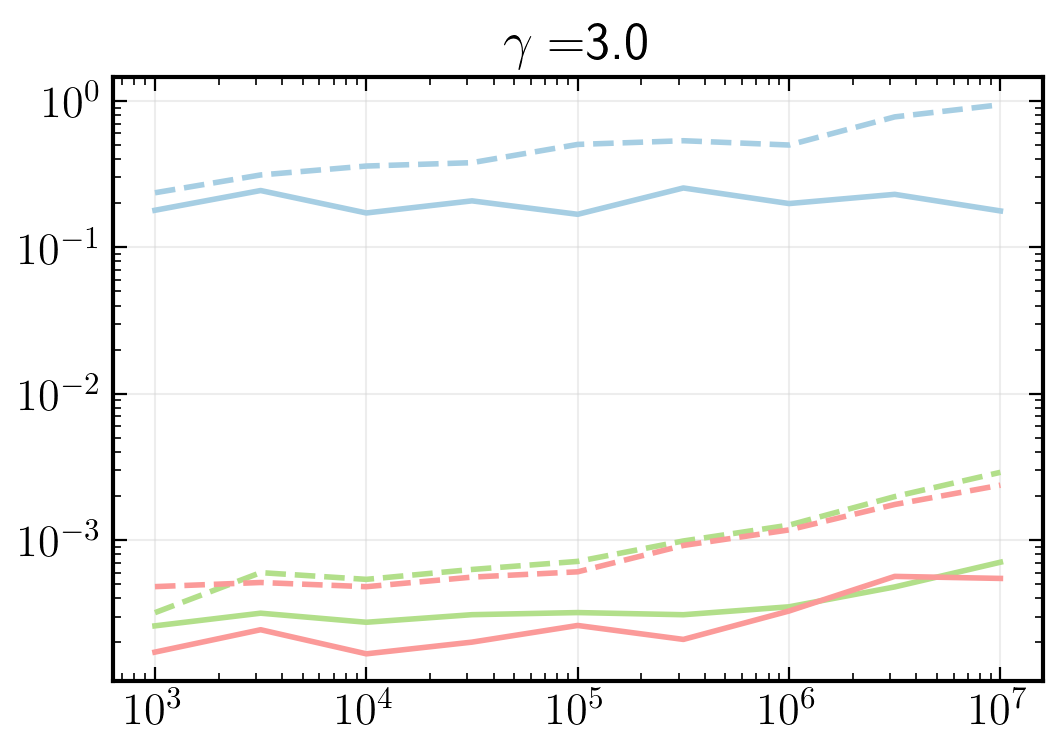

In [19]:
for gamma in inj_gamma:
    fig = plt.figure(dpi=200)
    for ii, sd in enumerate(all_gamma_results[gamma].keys()):
        one_tev_sens = conv_ref_en(all_gamma_results[gamma][sd]['sens_e2dnde'], 1., 100., gamma)
        one_tev_disc = conv_ref_en(all_gamma_results[gamma][sd]['disc_e2dnde'], 1., 100., gamma)
        plt.plot(all_gamma_results[gamma][sd]['delta_t'], one_tev_sens,
                color=palette[2*ii], lw=2., ls='-')
        plt.plot(all_gamma_results[gamma][sd]['delta_t'], one_tev_disc,
                color=palette[2*ii], lw=2., ls='--')
    
    plt.yscale('log')
    plt.title(r'$\gamma =$' + f'{gamma}')
    plt.xscale('log')
    plt.show()

In [ ]:
import pickle
with open('./gfu_offline_transient_sens_100tev.pkl', 'wb') as f:
    pickle.dump(all_gamma_results, f)

## Now with GFUOnline
Start by making a GFUOnline DataSpecs object because it isn't included in csky by default

In [ ]:
class GFUOnlineDataSpecs(object):
    class GFUOnlineDataSpec(cy.selections.TrackSpec):
        _bins_sindec = np.unique(np.concatenate([
             np.linspace(-1, -0.93, 4 + 1),
             np.linspace(-0.93, -0.3, 10 + 1),
             np.linspace(-0.3, 0.05, 9 + 1),
             np.linspace(0.05, 1, 18 + 1) ]))
        _bins_logenergy = np.arange(1, 9.5 + 0.01, 0.125)
        def dataset_modifications(self, ds):
            max_sigma = np.radians(15)
            ds.data = ds.data[ds.data.sigma < max_sigma]
            ds.sig = ds.sig[ds.sig.sigma < max_sigma]
            #ds.data.sigma = np.minimum(ds.data.sigma, max_sigma)
            #ds.sig.sigma = np.minimum(ds.sig.sigma, max_sigma)

    class GFUOnline_IC86 (GFUOnlineDataSpec):
        _path_sig = 'gfu_online/{version}/IC86_2011_MC.npy'
        _path_data = ['gfu_online/{{version}}/IC86_201{}_data.npy'.format(i) for i in range(1,9)]
        _path_grls = ['gfu_online/{{version}}/GRL/IC86_201{}_data.npy'.format(i) for i in range(1,9)]
        def __init__(self, years=list(map(str, 2010 + np.arange(1, 9)))):
            self.path_data = ['gfu_online/{{version}}/IC86_{}_data.npy'.format(y) for y in years]
            self.path_grls = ['gfu_online/{{version}}/GRL/IC86_{}_data.npy'.format(y) for y in years]
            self._key = 'GFUOnline_for_' + '_'.join(years)

    gfuonline_IC86 = [GFUOnline_IC86]

In [ ]:
ana_dir = cy.utils.ensure_dir('/data/user/apizzuto/csky_cache/')
with time('ana setup'):
    ana = cy.analysis.Analysis(cy.selections.repo, [GFUOnlineDataSpecs.GFUOnline_IC86])

In [ ]:
conf = {'extended': True,
       'space': "ps",
        'time': "transient",
        'sig': 'transient',
       }
cy.CONF['mp_cpus'] = 5
sinDecs = [-0.5, 0.0, 0.5]
inj_gamma = [2.0, 2.5, 3.0]
delta_ts = np.logspace(3., 7., 9)

all_gamma_results_online = dict()

for gamma in inj_gamma:
    all_gamma_results_online[gamma] = dict()
    for sd in sinDecs:
        results = dict(sens_n = [],
                  sens_e2dnde = [],
                  disc_n = [],
                  disc_e2dnde = [],
                  delta_t = [])
        dec = np.arcsin(sd)
        for delta_t in delta_ts:
            src = cy.utils.Sources(ra=0.0,
                                   dec=dec,
                                   mjd=57000.,
                                   sigma_t=0.,
                                   t_100=delta_t/86400.)
            cy.CONF['src'] = src

            tr = cy.get_trial_runner(conf, ana=ana, src=src,
                                     inj_conf={'flux': cy.hyp.PowerLawFlux(gamma)})
            bg = cy.dists.Chi2TSD(tr.get_many_fits(5000))

            sensitivity = tr.find_n_sig(bg.median(), 0.9,
                                   batch_size=50,
                                   n_sig_step=3,
                                   max_batch_size=0,
                                   logging=False,
                                   n_bootstrap=1)

            thresh_ts = bg.isf_nsigma(5.)
            discovery = tr.find_n_sig(thresh_ts, 0.5,
                                   batch_size=50,
                                   n_sig_step=3,
                                   max_batch_size=0,
                                   logging=False,
                                   n_bootstrap=1)
            
            results['sens_n'].append(sensitivity['n_sig'])
            results['disc_n'].append(discovery['n_sig'])
            results['sens_e2dnde'].append(tr.to_E2dNdE(sensitivity, E0=100, unit=1e3))
            results['disc_e2dnde'].append(tr.to_E2dNdE(discovery['n_sig'], E0=100, unit=1e3))
            results['delta_t'].append(delta_t)
            
        all_gamma_results_online[gamma][sd] = results

In [ ]:
PLOTEROO

In [ ]:
with open('./gfu_online_transient_sens_100tev.pkl', 'wb') as f:
    pickle.dump(all_gamma_results_online, f)

In [ ]:
PLOTEROO BOTH